# Autograd: automatic differentiation

When executing tensor operations, PyTorch can automatically construct on-the-fly the graph of operations to compute the gradient of any quantity with respect to any tensor involved.

More information on autotomatic differentiation in Pytorch [here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)

## Visualizing the computational graph

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch

PyTorchViz is a small package to create visualizations of PyTorch execution graphs and traces.

In [2]:
!pip install torchviz


     |████████████████████████████████| 51kB 3.9MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=f182af2658d4e556a58176052dda44a02f64f7dc4d5b5c32a14e5fbb82da2caf
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [0]:
import torchviz

Inn order to enable automatic differentiation, PyTorch keeps track of all operations involving tensors for which the gradient may need to be computed (i.e., require_grad is True). The operations are recorded as a directed graph. 

Torch tensors are recalled [here](https://pytorch.org/docs/stable/tensors.html) 



In [31]:
x = torch.ones(2, 2)
print(x)

tensor([[1., 1.],
        [1., 1.]])


A Tensor has a Boolean field *requires_grad*, set to False by default, which states if PyTorch should build the graph of operations so that gradients wrt to it can be computed.

In [5]:
x.requires_grad

False

In [6]:
x.numpy()

array([[1., 1.],
       [1., 1.]], dtype=float32)

In [7]:
x.requires_grad_(True)
x.requires_grad

True

### Question: The following cell gives an error. Why?

In [8]:
x.numpy()

RuntimeError: ignored

---
> We can't use the .numpy() method on a variable that requires grad, which we set for x 2 cells above.
---

In [0]:
y = x.data.numpy() # Torch.data returns the "data" (array_like) stored in the tensor

In [10]:
y[0]=2
print(y)
print(x)

[[2. 2.]
 [1. 1.]]
tensor([[2., 2.],
        [1., 1.]], requires_grad=True)


In [11]:
x.requires_grad

True

tensor([[4., 4.],
        [3., 3.]], grad_fn=<AddBackward0>)


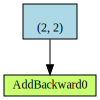

In [12]:
y = x + 2
print(y)
torchviz.make_dot(y)

**Broadcasting**

Recall: Broadcasting **automatically** expands dimensions by replicating coefficients, when it is necessary to perform operations.

1. If one of the tensors has fewer dimensions than the other, it is reshaped by adding as many dimensions of size 1 as necessary in the front; then
2. for every mismatch, if one of the two tensor is of size one, it is expanded along this axis by replicating  coefficients.

If there is a tensor size mismatch for one of the dimension and neither of them is one, the operation fails.

In [13]:
A = torch.tensor([[1.], [2.], [3.], [4.]])
print(A.size())
print(A)
B = torch.tensor([[5., -5., 5., -5., 5.]])
print(B.size())
print(B)
C = A + B
print(C)

torch.Size([4, 1])
tensor([[1.],
        [2.],
        [3.],
        [4.]])
torch.Size([1, 5])
tensor([[ 5., -5.,  5., -5.,  5.]])
tensor([[ 6., -4.,  6., -4.,  6.],
        [ 7., -3.,  7., -3.,  7.],
        [ 8., -2.,  8., -2.,  8.],
        [ 9., -1.,  9., -1.,  9.]])


Back to Autograd!

In [14]:
x = torch.ones(2, 2)
x.requires_grad_(True)
y = x+2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [15]:
y.requires_grad

True

Tensor and Function are interconnected and build up an acyclic graph, that encodes a complete history of computation. 

Each tensor has a .grad_fn attribute that references a Function that has created the Tensor (except for Tensors created by the user - their grad_fn is None).

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
None
tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


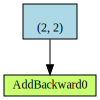

In [0]:
print(x)
print(x.grad_fn)
print(y)
print(y.grad_fn)
torchviz.make_dot(y) 

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>)


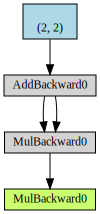

In [16]:
z = y * y * 3
print(z)
torchviz.make_dot(z) 

tensor(27., grad_fn=<MeanBackward0>)


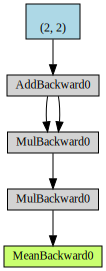

In [17]:
out = z.mean()
print(out)
torchviz.make_dot(out) 

After the computation is finished, i.e. _forward pass_, you can call ```.backward()``` and have all the gradients computed automatically.

In [0]:
out.backward()

The gradients w.r.t. this variable is accumulated into ```.grad```.

In [19]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


### Question: Explain mathematically the value of "x.grad"


---
> first let's summarize our variables and their relevant derivatives:

>$y=x+2, \frac{\mathrm dy}{\mathrm d x}=1$

>$z=3*y^2, \frac{\mathrm dz}{\mathrm dy} = 6y$

>$out = \frac{1}{4}\sum_{i=1}^{4}z_i,
\frac{\mathrm d_{out}}{\mathrm dz} = \frac{1}{4}$

> Putting it all together and using the chain rule:

> $x.grad = \frac{\mathrm d_{out}}{\mathrm dx}= \frac{\mathrm d_{out}}{\mathrm dz} * \frac{\mathrm dz}{\mathrm dy} * \frac{\mathrm dy}{\mathrm dx}$ 

> $x.grad =  \frac{1}{4} * 6y *1 = \frac{3}{2} * y $

> $x.grad = 
 \begin{pmatrix}
  4.5 & 4.5 \\
  4.5 & 4.5 
 \end{pmatrix}$
---

[Why can I not see .grad of an intermediate variable?](https://discuss.pytorch.org/t/why-cant-i-see-grad-of-an-intermediate-variable/94)

Gradients are only retained for leaf variables. 

Non-leaf variables’ gradients are not retained to be inspected later. This was done by design, to save memory.

In [23]:
print(y.grad)
print(out.grad)

None
None


tensor(10., grad_fn=<MeanBackward0>)


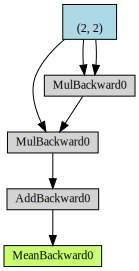

In [36]:
x = 2 * torch.ones(2, 2)
x.requires_grad_(True)
out = (x * x * x + 2 ).mean()
print(out)
torchviz.make_dot(out)

In [0]:
out.backward(torch.Tensor([2.0]))
#out.backward() #> this returns the matrix with 3. 

### Question: Explain mathematically the value of "x.grad" in the following cell

> $out = \frac{1}{4}\sum_{i=1}^{4} x_i^3+ 2 $

>$\frac{\mathrm d_{out}}{\mathrm d x}=\frac{3}{4}x^2$

>$x = 
 \begin{pmatrix}
  2. & 2. \\
  2. & 2. 
 \end{pmatrix}, x^2 = 
 \begin{pmatrix}
  4. & 4. \\
  4. & 4. 
 \end{pmatrix}$
 
 >$\frac{\mathrm d_{out}}{\mathrm d x}=\begin{pmatrix}
  3. & 3. \\
  3. & 3. 
 \end{pmatrix}$
 
 >Below we get twice that, because the parameter <torch.Tensor([2.0])> was passed into the backward method.  

In [38]:
print(x.grad) 

tensor([[6., 6.],
        [6., 6.]])


## How to compute the gradient when I want?



In [39]:
x = torch.ones(2, 2)
x.requires_grad_(True)
y = x+2
z = 3 * y ** 2 
out = z.mean()

out.backward(retain_graph=True)

print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


Calling again the "backward" process does not launch an error

In [0]:
out.backward(retain_graph=True)

In [41]:
print(x.grad)

tensor([[9., 9.],
        [9., 9.]])


In [42]:
torch.autograd.grad(out, out, retain_graph=True)

(tensor(1.),)

In [43]:
torch.autograd.grad(out, z, retain_graph=True)

(tensor([[0.2500, 0.2500],
         [0.2500, 0.2500]]),)

In [44]:
torch.autograd.grad(out, y, retain_graph=True)

(tensor([[4.5000, 4.5000],
         [4.5000, 4.5000]]),)

In [0]:
out.backward(torch.Tensor([2.0]), retain_graph=True)

In [46]:
print(x.grad)

tensor([[18., 18.],
        [18., 18.]])


## A last example

tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])


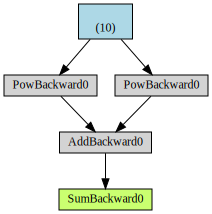

In [47]:
x=torch.ones(10, requires_grad=True)

y=x**2
z=x**3
r=(y+z).sum()

r.backward()
print(x.grad)
torchviz.make_dot(r) 

## Gradient accumulation


The gradients must be set to zero manually. Otherwise they will cumulate across several _.backward()_ calls. 
This accumulating behavior is desirable in particular to compute the gradient of a loss summed over several “mini-batches,” or the gradient of a sum of losses.


In [48]:
x = torch.ones(1, 1,requires_grad = True)
print(x)
out = (x+1)**2
print(out)

tensor([[1.]], requires_grad=True)
tensor([[4.]], grad_fn=<PowBackward0>)


In [49]:
out.backward(torch.ones(1,1),retain_graph=True) #(x+1)**2 --/dx--> 2(x+1) -> 4
print(x.grad)
out.backward(2 * torch.ones(1,1),retain_graph=True) # prevgrads + 2*(2(x+1)) -> 4+8
print(x.grad)
out.backward(retain_graph=True) #prevgrads + 2(x+1) -> 12+4
print(x.grad)

tensor([[4.]])
tensor([[12.]])
tensor([[16.]])


In [50]:
# Manually zero the gradients after updating weights
x.grad.data.zero_()

tensor([[0.]])

In [51]:
out.backward(torch.ones(1,1),retain_graph=True) 
print(x.grad)
x.grad.data.zero_()
out.backward(2 * torch.ones(1,1),retain_graph=True) #prevsgrad + 2*(2(x+1)) -> 0+8
print(x.grad)
x.grad.data.zero_()
out.backward(retain_graph=True) #prevsgrad + 2(x+1) -> 0+4
print(x.grad)


tensor([[4.]])
tensor([[8.]])
tensor([[4.]])


If you want to come back to the difference between detach and data see [Differences between .data and .detach](https://github.com/pytorch/pytorch/issues/6990)

# Playing with a neural network in pytorch: non-linear regression

## Non-linear regression with a neural network

An implementation of **(Batch) Gradient Descent** using the nn package. Here we have a super simple model with only one layer and no activation function!

Generate the dataset and visualize it.

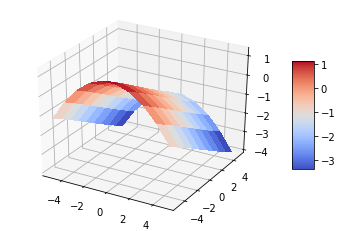

In [59]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


# Make data
num_samples = 10
X1 = np.linspace(-5, 5, num_samples) 
X2 = np.linspace(-5, 5, num_samples) 
X1grid, X2grid = np.meshgrid(X1, X2)
Y = -(0.1*X1grid**2 + 3*np.sin(0.1*X2grid) + 0.1) 

# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X1grid, X2grid, Y, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [53]:
x1n = X1grid.ravel().reshape(-1, 1)
x2n = X2grid.ravel().reshape(-1, 1)
xn = np.concatenate((x1n,x2n),axis=1)
yn = Y.ravel().reshape(-1, 1)
print(xn.shape)
print(yn.shape)

# Convert in pytorch tensors
x = torch.from_numpy(xn).float()
y = torch.from_numpy(yn).float()
print(x.shape)
print(y.shape)

(100, 2)
(100, 1)
torch.Size([100, 2])
torch.Size([100, 1])


## Neural network with full implementation (gradient computation and estimate update)

In [60]:
import torch

dtype = torch.float


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = num_samples**2, 2, 100, 1

# Randomly initialize weights
w1 = torch.randn(D_in, H, dtype=dtype)
w2 = torch.randn(H, D_out,  dtype=dtype)

learning_rate = 1e-6 #1e-6
for t in range(10001):
    # Forward pass: compute predicted y
    h = x.mm(w1) #H = X . W1
    
    h_relu = h.clamp(min=0) #proj: x-->x+, relu function Hrelu = SIGMArelu(H)
    y_pred = h_relu.mm(w2) # Ypred = Hrelu . W2
    #print(y_pred)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item() 
    if t % 1000 == 0: #print an update every 1000 loop
        print(t, loss) 

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y) #dloss/dy
    grad_w2 = h_relu.t().mm(grad_y_pred) #Ypred=Hrelu.W2<=if T exists=> W2=Hrelu.t().Ypred then grad
    grad_h_relu = grad_y_pred.mm(w2.t()) #Ypred=Hrelu.W2<=if T exists=> Hrelu=Ypred.W2.t() then grad
    grad_h = grad_h_relu.clone() 
    grad_h[h < 0] = 0 #project x-->x+
    grad_w1 = x.t().mm(grad_h) #H=X.W1<=if T exists=> W1=X.t().H then grad
    

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

0 118065.8125
1000 44.27510452270508
2000 21.432743072509766
3000 14.417535781860352
4000 11.708582878112793
5000 10.317084312438965
6000 9.417608261108398
7000 8.801108360290527
8000 8.255293846130371
9000 7.794061660766602
10000 7.401810169219971


Compare the first values

In [61]:
print(y[0:5])
print(y_pred[0:5])

tensor([[-1.1617],
        [-0.1741],
        [ 0.5667],
        [ 1.0605],
        [ 1.3074]])
tensor([[-0.7463],
        [-0.0850],
        [ 0.5630],
        [ 0.9901],
        [ 1.4472]])


Plot the approximation in 1D

In [0]:
def plotApproximation(y,y_pred):
  plt.figure(figsize=(6, 4))
  plt.plot(y.detach().numpy(),'b-')
  plt.plot(y_pred.detach().numpy(),'r-*')
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.title('Approximation with the neural network')
  plt.show()

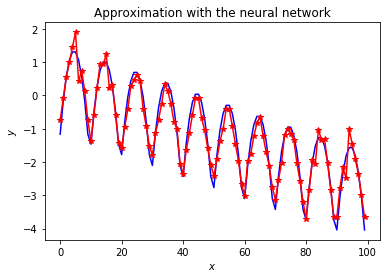

In [63]:
plotApproximation(y,y_pred)

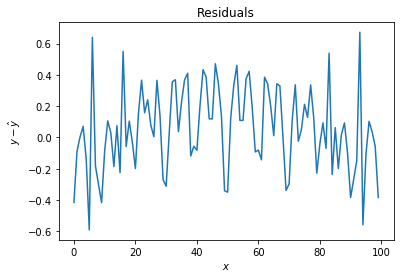

In [64]:
plt.figure(figsize=(6, 4))
plt.plot(y.numpy()-y_pred.numpy())
plt.title('Residuals')
plt.xlabel('$x$')
plt.ylabel('$y-\hat{y}$')
plt.show()

## Neural network with automatic gradient computation (but still the explicit estimate update)


A fully-connected ReLU network with one hidden layer, trained to predict y from x
by minimizing squared Euclidean distance.

This implementation uses the nn package from PyTorch to build the network.
PyTorch autograd makes it easy to define computational graphs and take gradients,
but raw autograd can be a bit too low-level for defining complex neural networks;
this is where the nn package can help. The nn package defines a set of Modules,
which you can think of as a neural network layer that has produces output from
input and may have some trainable weights.

### Question: use autograd to compute the gradient. You can start from the full implementation of the neural network.

In [65]:
import torch

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = num_samples**2, 2, 100, 1

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-6
for t in range(10001):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    if t % 1000 == 0:
        print(t, loss.item())
        
    # Complete here
    ## Backprop using autograd - it will compute the grad of loss
    ## with respect to all Tensors that have requires_grad=True.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
          # Complete the update
            param -= learning_rate * param.grad
            
            # Manually zero the gradients after updating weights
            param.grad.data.zero_()

0 412.365234375
1000 12.543134689331055
2000 6.946115016937256
3000 5.415310382843018
4000 4.805426120758057
5000 4.433838367462158
6000 4.148762226104736
7000 3.9135894775390625
8000 3.7147860527038574
9000 3.5453708171844482
10000 3.400580883026123


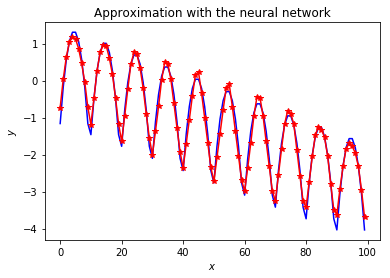

In [66]:
plotApproximation(y,y_pred)

## Neural network with automatic gradient computation and automatic estimate update

A fully-connected ReLU network with one hidden layer, trained to predict y from x
by minimizing squared Euclidean distance.

This implementation uses the nn package from PyTorch to build the network.

Rather than manually updating the weights of the model as we have been doing,
we use the optim package to define an Optimizer that will update the weights
for us. The optim package defines many optimization algorithms that are commonly
used for deep learning, including SGD+momentum, RMSProp, Adam, etc.

### Question: use the Torch optimizer to do the gradient descent. You can start from the full implementation of the neural network with automatic differentiation.

Details on Optimizer are [here](https://pytorch.org/docs/stable/optim.html)

In [69]:
import torch

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = num_samples**2, 2, 100, 1

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us.
learning_rate = 1e-6

# Declare something here 
## Contructing the optimizer with the parameters to optimize. 
optimizer = torch.optim.SGD(model.parameters(), 
                      lr=learning_rate, 
                      momentum=0.9)

for t in range(10001):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 1000 == 0:
        print(t, loss.item())
        
    # Complete here
    ## Before the backward pass, use the optimizer object to 
    ## zero all of the gradients for the Tensors it will update
    optimizer.zero_grad()
    
    ## backward prop
    loss.backward()
    
    ## step method to update the parameters
    optimizer.step()



0 236.02442932128906
1000 4.390051364898682
2000 2.972238540649414
3000 2.608971357345581
4000 2.450198173522949
5000 2.348001003265381
6000 2.2701919078826904
7000 2.2036221027374268
8000 2.144470691680908
9000 2.089712142944336
10000 2.039581060409546


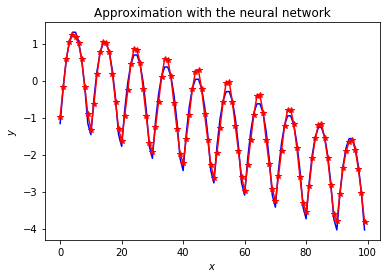

In [70]:
plotApproximation(y,y_pred)

Conclusion
---

---
We've implemented a neural network algorithm in PyTorch in 3 ways: 
- full implementation which meant computing many gradients, 
- automatic gradient computation, using autograd/backward, but still explicit estimate update (implementing GD for the weights)
- automatic gradient computation and estimate update using autograd/backward + optim

The value of our loss function after 10,000 iterations decreased as we implemented more automatic algorithms. 

---